In [2591]:
import os
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

# importing data and adding symbol to dataframe
data = pd.read_csv(os.getcwd()+"\\AAPL.csv")
data['sym'] = ['AAPL' for i in range(len(data))]

In [2651]:
class market_data:
    
    def __init__(self, stock_data):
        self.stock_data = self.prep_data1(stock_data)
        
    def prep_data1(self, data):
        data['datetime'] = pd.to_datetime(data['Date'])
        data['logret'] =  [0]+[np.log(data['Close'].iloc[i+1]/data['Close'].iloc[i]) for i in range(len(data)-1)]
        return data.drop(columns = ['Date'])
        
    # plots a given symbol with y_label being (Open, High, Low, etc)
    def plot_price(self, symbol, y_label):
        df = self.stock_data[self.stock_data['sym'] == symbol]        
        plt.figure(figsize = (10,5))
        plt.plot(df['datetime'], df['Adj Close'], linewidth = 2, color = 'k')
        plt.title(symbol)
        plt.xlabel('Datetime')
        plt.ylabel(y_label)
        plt.show()
    

class options(market_data):
    def __init__(self, stock_data, option_data):
        super().__init__(stock_data)
        self.option_data = self.prep_data2(option_data)
        
    def order_handler(self, option):
        o = option['order']
        if o == 'sell':
            return 1
        elif o == 'buy':
            return -1
        
    def prep_data2(self, option_data):
        # finds timedelta and converts to years(float) (252 trading days in year)
        if 'dt' not in option_data:
            dt = (self.stock_data.datetime.max()-self.stock_data.datetime.min()).days/252
            for dat in option_data:
                dat['dt'] = dt
        return option_data
    
    def N(self, x):
        return scipy.stats.norm(0,1).cdf(x)
    
    def d(self, opt):
        # calculating d1 and d2
        d1 = (np.log(opt['S']/opt['E']) + (opt['r'] + .5*opt['sigma']**2)*(opt['dt']))/(opt['sigma']*np.sqrt(opt['dt']))
        d2 = d1 - opt['sigma']*np.sqrt(opt['dt'])
        return d1, d2
    
    # rounding delta with 4sigfigs and price to 2sigfigs
    def BSM(self):
        # shortening variable name
        option_data = self.option_data
        
        DELTA = []
        V = []
        
        for dat in option_data:
            
            d1, d2 = self.d(dat)
            # payoffs 
            if dat['type'] == 'call':
                if dat['dt'] > 0:
                    DELTA.append(self.N(d1))
                    V.append(dat['S']*self.N(d1) - dat['E']*np.exp(-dat['r']*dat['dt'])*self.N(d2))
                else:
                    DELTA.append(.5*(np.sign(dat['S']-dat['E'])+1))
                    V.append(max(dat['S']-dat['E'],0))
            elif dat['type'] == 'put':
                if dat['dt'] > 0:
                    DELTA.append(-self.N(-d1))
                    V.append(dat['E']*np.exp(-dat['r']*dat['dt'])*self.N(-d2) - dat['S']*self.N(-d1))
                else:
                    DELTA.append(.5*(-1*np.sign(dat['S']-dat['E'])+1))
                    V.append(max(dat['E']-dat['S'],0))
            # rounding values
        return [round(i,2) for i in DELTA], [round(i,2) for i in V]
    
    # note that that this updates self.option_data's sigma as well as retursn the value
    def implied_vol(self):
        # The routine below is repeated for each option in the portfolio
        epsillon = 0.01 # 1 cent
        
        for i in range(len(self.option_data)):
            if 'sigma' not in self.option_data[i]:
                self.option_data[i]['sigma'] = 1
    
        # updates sigma until V converges to observed price for each option in portfolio
        index = 0
        while index != len(self.option_data):
            delta, V = self.BSM()
            diff = V[index]-self.option_data[index]['observed']
            
            if diff < 0:
                self.option_data[index]['sigma'] += diff/1000
            else:
                self.option_data[index]['sigma'] -= diff/1000
            # convergence condition
            if abs(diff) < epsillon:
                index+=1   
        return [round(i['sigma'],4) for i in self.option_data], delta
    
    # 'hedge_dates' = {'AAPL': [datetime1, datetime2, ...], 'GM': [datetime1, datetime2, ...]}
    def deltahedge(self, hedge_dates, bool_print):
        
        s_dat = self.stock_data
        dates = s_dat['datetime'].values
        symbols = [i['sym'] for i in self.option_data]
        account = [{'delta': [0], 'trades': [0], 'balance': [0]} for i in symbols]
    
        for d in dates:
            for sym in symbols:
                
                # this try, except statement deals with the fact that you may have an option in your portfolio 
                # that you arent actively trying to hedge
                try:
                    if d in hedge_dates[sym]:
        
                        # updates the price for each unique symbo
                        price = s_dat[(s_dat['sym'] == sym) & (s_dat['datetime'] == d)]['Close'].values[0]
                        self.option_data[symbols.index(sym)]['S'] = price
                        self.option_data[symbols.index(sym)]['dt'] = ((dates[-1]-d)).days/252
                except:
                    pass
            delta, V = self.BSM() # delta = [d1, d2, ...], V = [v1, v2, ...]
            
            for i in range(len(symbols)):
                
                sign = self.order_handler(self.option_data[i])
                # initial action
                if str(d)[:10] == str(hedge_dates[sym][0])[:10]:
                    account[i]['balance'][0] = 100*V[i]*np.sign(delta[i])*sign
                
                # accounting for interest
                try:
                    dt = ((hedge_dates[symbols[i]][-1]-hedge_dates[symbols[i]][-2])).days/252
                    account[i]['balance'][-1] = round(account[i]['balance'][-1]*np.exp(self.option_data[i]['r']*dt),2)
                    account[i]['delta'].append(delta[i])
                    action = round((delta[i]-account[i]['delta'][-2])*100)
                    account[i]['trades'].append(action)
                    S = self.option_data[i]['S']
                    account[i]['balance'].append(account[i]['balance'][-1]-action*S*sign)
                except:
                    pass
        
        value = 0
        for i in range(len(account)):
            shares = account[i]['delta'][-1]*100
            S = self.option_data[i]['S']
            V_i = V[i]*100
            value += account[i]['balance'][-1] + sign*(S*shares - V_i)
            print(value)
        value = round(value,2)
            
        # printout 
        if bool_print == True:
            print('Final Balance: ${}\n'.format(value))
            for i in range(len(symbols)):
                print('----- {}'.format(symbols[i]))
                p = account[i]
                for item in p.items():
                    print(item)
        return value, account
    
    def realized_vol(self):
        dates = pd.to_datetime(self.stock_data['datetime'].values)
        return (1/np.sqrt((dates[-1]-dates[0]).days/252))*self.stock_data['logret'].std()    

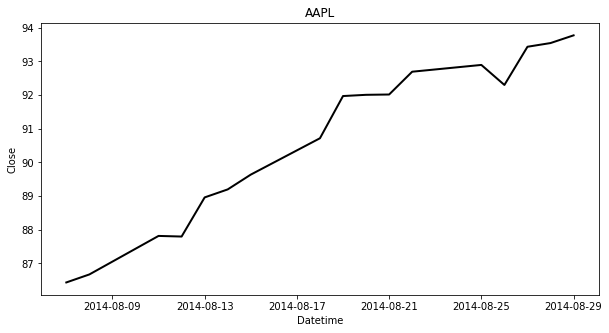

In [2652]:
X = market_data(data)
X.plot_price('AAPL', 'Close')

# Remarks

- This code can deal with hedging options spreads.
- For ...deltahedge(hedge_dates)...... hedge_times is a dictionary of dates on which to hedge each asset in portfolio. For example, {'AAPL': [d1], 'BABA': [d1, d2, d3]} would hedge AAPL once prior to expiration and BABA 3 times.
- This assumes a constant volatility. All I would have to do to calibrate the hedging with a volatility model would be to add a new paramater to the hedging routine that has volatility estimates for each d_i ...deltahedge(hedge_dates, vol_model). 

$\textbf{Exercise 6.1.}$ On Aug 7, 2014 the stock AAPL closed at \\$94.48. At this time, the call with strike \\$94 and expiration Aug 29, 2014 was traded at \\$2.425 (midprice). Assume the rate is 0.0015. In all following questions assume you sold a call for \\$2.425.

Source: https://www.math.tamu.edu/~berko/teaching/common/math425/CourseExercises.pdf


In [2664]:
portfolio = [{'sym': 'AAPL', 'order': 'sell', 'type': 'call', 'observed': 2.425, 'S':  94.48, 'E': 94, 'r': .0015}]
O = options(data, portfolio)

#### What’s the implied volatility? Corresponding delta?

In [2665]:
implied_vol, delta = O.implied_vol()
print("Implied Volatility: {}\nDelta: {}".format(implied_vol, delta))

Implied Volatility: [0.1963]
Delta: [0.55]


#### Assume you do not hedge (just deposit the option premium in the bank). What’s your profit or loss at the expiration time?

In [2666]:
V = 2.425
last_price = data['Close'].iloc[-1]
final_balance = round(V*np.exp(.0015*16/52) - 100*max(0, last_price - 94),2)
print('Final Balance: ${}'.format(final_balance))

Final Balance: $-847.57


#### Assume you hedge daily using implied volatility as your sigma. What’s your profit or loss at the expirationtime?

In [2667]:
# In the previous step, by calling the implied_vol method the 'params' variable 
# was updated with the implied volatility. If the method wasn't called sigma would remain the same (4).

daily = pd.to_datetime(O.stock_data.datetime.values)
hedge_dates = {'AAPL':daily}

final_balance, account = O.deltahedge(hedge_dates, True)

-24.200000000000728
Final Balance: $-24.2

----- AAPL
('delta', [0, 0.55, 0.57, 0.65, 0.65, 0.73, 0.75, 0.77, 0.83, 0.88, 0.88, 0.88, 0.91, 0.91, 0.89, 0.93, 0.93, 0.94])
('trades', [0, 55.0, 2.0, 8.0, 0.0, 8.0, 2.0, 2.0, 6.0, 5.0, 0.0, 0.0, 3.0, 0.0, -2.0, 4.0, 0.0, 1.0])
('balance', [243.0, -4953.43, -5142.94, -5910.9, -5910.94, -6688.9, -6883.94, -7079.94, -7674.95, -8177.65, -8177.7, -8177.75, -8481.76, -8481.81, -8280.08, -8688.65, -8688.7, -8791.2])


#### Calculate the volatility realized by these historical prices. Re-do delta-hedging using the historical volatility as your sigma (you still sold the option for 2.425). What’s your profit or loss at the expiration time?

In [2668]:
rv = O.realized_vol()

portfolio =  [{'sym': 'AAPL', 'order': 'sell', 'type': 'call', 'sigma': rv, 'S':  94.48, 'E': 94, 'r': .0015}]
O = options(data, portfolio)

In [2669]:
print('Realized Volatility: {}\n'.format(round(rv,4)))
final_balance, portfolio = O.deltahedge(hedge_dates, True)

Realized Volatility: 0.0204

-11.1299999999992
Final Balance: $-11.13

----- AAPL
('delta', [0, 0.81, 0.91, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
('trades', [0, 81.0, 10.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
('balance', [55.0, -7597.93, -8545.38, -9409.35, -9409.41, -9409.47, -9409.53, -9409.59, -9409.65, -9409.71, -9409.77, -9409.83, -9409.89, -9409.95, -9410.01, -9410.07, -9410.13, -9410.13])


#### What is better and why: no hedging, hedging with implied volatility or hedging with realized volatility? What if the prices were exhibiting the same (realized) volatility but were going down instead of up?

$ RV > IV > \neg{hedging} $

Without hedging, you are entirely exposed to the risk of holding the option. By hedging using IV, you are actively building a replicating portfolio that offsets the risk of holding an option. Lastly, simulating hedging with realized volatility is optimal because you have a look back bias that allows you to know exactly how volitile the market will be, and thus can hedge appropriately. The reason the final balance is still non-zero (analagous to hedging away all risk) is because our trading frequency is daily and we hedged with a constant sigma. In reality, one would have found an optimal hedging procedure under the constraints of transaction fees and the ability of their volatility model to correctly forcast market volatility. 